# Configuration de MLFlow avec tracking local

In [1]:
# pip install mlflow
import mlflow

In [2]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Cr√©ation de l'exp√©rimentation "approche classique"
mlflow.set_experiment("modele_avanc√©")

<Experiment: artifact_location='mlflow-artifacts:/566106427225564143', creation_time=1729147540629, experiment_id='566106427225564143', last_update_time=1729147540629, lifecycle_stage='active', name='modele_avanc√©', tags={}>

# Word2Vec

In [3]:
# # utilisation dans Google collab
# print('Mounting your Google Drive...')
# from google.colab import drive
# drive.mount('/content/drive')
# print('Opening the file...')
# %cd /content/drive/My Drive/P7
# !ls

In [4]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [5]:
import multiprocessing
# Param√®tres du mod√®le Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fen√™tre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour √™tre pris en compte
w2v_epochs = 100      # Nombre d'it√©rations (√©poques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les c≈ìurs disponibles

### Donn√©es

In [6]:
import pandas as pd

train_df = pd.read_csv("./data/train_df.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv("./data/test_df.csv")
test_df = test_df.iloc[:, 1:]

### Pr√©paration des sentences

In [7]:
# Pr√©paration des sentences √† partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en s√©parant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Mod√®le Word2Vec

In [8]:
from gensim.models import Word2Vec
# Instanciation du mod√®le Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenis√©es d'entra√Ænement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fen√™tre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) √† utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [9]:
# Entra√Ænement du mod√®le
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)


(2803424, 3447500)

In [10]:
# Sauvegarde du mod√®le apr√®s entra√Ænement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [11]:
# Taille du vocabulaire (le nombre de mots uniques)
vocab_size = len(w2v_model.wv.index_to_key)

# Extraction de la matrice d'embedding
embedding_matrix = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix = np.array(embedding_matrix)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix.shape)

Matrice d'embedding de taille : (6006, 300)


### Mod√®les tests d'embedding Keras

Les essais avec un mod√®le simple (LSTM et dense) ont montr√© un sur-apprentissage important. Il faut l'optimiser avec dropout, regularisation.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Param√®tres
maxlen = 40  # Longueur maximale des s√©quences de mots
vocab_size = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire
print("Taille du vocabulaire dans W2Vec :", vocab_size)

Taille du vocabulaire dans W2Vec : 6006


In [14]:
# Instanciation du mod√®le s√©quentiel 1
model_W2v_1 = Sequential()

# Ajout de la couche d'embedding avec la matrice pr√©-entra√Æn√©e
model_W2v_1.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Utilisation de la matrice d'embedding pr√©-entra√Æn√©e
    trainable=False             # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations s√©quentielles
model_W2v_1.add(LSTM(128))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model_W2v_1.add(Dense(1, activation='sigmoid'))

# Compilation du mod√®le
model_W2v_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
model_W2v_1.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)                ‚îÇ ?                           ‚îÇ       1,801,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                          ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [15]:
# Instanciation du mod√®le s√©quentiel 2
from tensorflow.keras.regularizers import l2

# Ajout de la r√©gularisation L2 dans la couche LSTM et la couche Dense
model_W2v_2 = Sequential()
model_W2v_2.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model_W2v_2.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la r√©gularisation L2
model_W2v_2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du mod√®le
model_W2v_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Affichage du r√©sum√© du mod√®le
model_W2v_2.summary()

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)              ‚îÇ ?                           ‚îÇ       1,801,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                        ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [17]:
# Mod√®le 3 avec dropout

from tensorflow.keras.layers import Dropout

# Ajout de Dropout apr√®s la couche LSTM pour pr√©venir l'overfitting
model_W2v_3 = Sequential()
model_W2v_3.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model_W2v_3.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la r√©gularisation L2
model_W2v_3.add(Dropout(0.5))  # Dropout de 50% des neurones
model_W2v_3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du mod√®le
model_W2v_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
model_W2v_3.summary()

Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)              ‚îÇ ?                           ‚îÇ       1,801,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                        ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [18]:
# R√©duction du nombre d'unit√©s dans la couche LSTM
model_W2v_4 = Sequential()
model_W2v_4.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                # input_length=maxlen,
                trainable=False))
model_W2v_4.add(LSTM(64, kernel_regularizer=l2(0.01)))  # Moins d'unit√©s LSTM
model_W2v_3.add(Dropout(0.5))  # Dropout de 50% des neurones
model_W2v_4.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compilation du mod√®le
model_W2v_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_W2v_4.summary()

Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_3 (Embedding)              ‚îÇ ?                           ‚îÇ       1,801,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_3 (LSTM)                        ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

In [19]:
# Code du mod√®le avec GRU, Dropout et r√©gularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Param√®tres de r√©gularisation et Dropout
dropout_rate = 0.5      # Pourcentage de neurones ignor√©s
l2_lambda = 0.01        # Facteur de r√©gularisation L2
learning_rate = 0.0001  # Taux d'apprentissage sp√©cifique

# Instanciation du mod√®le s√©quentiel
model_W2v_5 = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pr√©-entra√Æn√©e
model_W2v_5.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Matrice d'embedding pr√©-entra√Æn√©e
    # input_length=maxlen,        # Longueur maximale des s√©quences
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et r√©gularisation L2
model_W2v_5.add(GRU(
    units=128,                    # Nombre d'unit√©s GRU
    kernel_regularizer=l2(l2_lambda),  # R√©gularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # R√©gularisation L2 sur les poids r√©currents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions r√©currentes
))

# 3. Couche de sortie Dense avec r√©gularisation L2
model_W2v_5.add(Dense(
    units=1,                      # Pour une t√¢che de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilit√© binaire
    kernel_regularizer=l2(l2_lambda)  # R√©gularisation L2 sur la couche de sortie
))

# D√©finir l'optimiseur Adam avec un learning rate sp√©cifique
optimizer = Adam(learning_rate=learning_rate)

# Compilation du mod√®le
model_W2v_5.compile(
    optimizer=optimizer,          # Utiliser l'optimiseur Adam avec le learning rate d√©fini
    loss='binary_crossentropy',   # Fonction de perte pour une classification binaire
    metrics=['accuracy']          # M√©trique d'accuracy
)

# Affichage du r√©sum√© du mod√®le
model_W2v_5.summary()


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_4 (Embedding)              ‚îÇ ?                           ‚îÇ       1,801,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ gru (GRU)                            ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ ?                           ‚îÇ     0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,801,800 (6.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,801,800 (6.87 MB)

### Pr√©paration des donn√©es pour l'ex√©cution du mod√®le

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cr√©ation d'un dictionnaire mot->index √† partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en s√©quences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entra√Ænement et de test en s√©quences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des s√©quences pour qu'elles aient toutes la m√™me longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des s√©quences apr√®s padding
print(train_padded[:5])


[[ 165   65  990 2556 2546  957    6  167 1161  419  867 1145   32 2684
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 406   16  750    3    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2726  838   28  101   32    4   14    5   86    5   41  101   72   90
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2520 2594 2424  450   54  612  193 2549   19    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2618 2686    5  419    5   55  105  177   81    6  179  496  239
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [21]:
y_train = train_df['target'].values
y_test = test_df['target'].values

### Entrainement du mod√®le d'embedding

In [30]:
n_epchos = 12
batch_size = 64

In [31]:
# Entra√Ænement du mod√®le 1 avec validation et sauvegarde de l'historique
history_w2v_1 = model_W2v_1.fit(
    train_padded,         # Donn√©es d'entra√Ænement
    y_train,              # √âtiquettes d'entra√Ænement
    epochs=n_epchos,            # Nombre d'√©poques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les donn√©es de test
    verbose=1             # Afficher l'√©volution pendant l'entra√Ænement
)

Epoch 1/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - accuracy: 0.5054 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6931
Epoch 2/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.5025 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 3/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4962 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 4/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4974 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 5/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.5029 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.6931
Epoch 6/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4990 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.693

In [32]:
# Entra√Ænement du mod√®le 2 avec validation et sauvegarde de l'historique
history_w2v_2 = model_W2v_2.fit(
    train_padded,         # Donn√©es d'entra√Ænement
    y_train,              # √âtiquettes d'entra√Ænement
    epochs=n_epchos,            # Nombre d'√©poques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les donn√©es de test
    verbose=1             # Afficher l'√©volution pendant l'entra√Ænement
)

Epoch 1/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4986 - val_loss: 0.6932
Epoch 2/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4880 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6934
Epoch 3/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4780 - loss: 0.6936 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 4/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.5102 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 5/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4905 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 6/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.5088 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.693

In [33]:
# Entra√Ænement du mod√®le 3 avec validation et sauvegarde de l'historique
history_w2v_3 = model_W2v_3.fit(
    train_padded,         # Donn√©es d'entra√Ænement
    y_train,              # √âtiquettes d'entra√Ænement
    epochs=n_epchos,            # Nombre d'√©poques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les donn√©es de test
    verbose=1             # Afficher l'√©volution pendant l'entra√Ænement
)

Epoch 1/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - accuracy: 0.5060 - loss: 4.3730 - val_accuracy: 0.4986 - val_loss: 0.8438
Epoch 2/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4870 - loss: 4.6193 - val_accuracy: 0.4986 - val_loss: 0.8665
Epoch 3/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 23ms/step - accuracy: 0.5147 - loss: 4.0906 - val_accuracy: 0.4986 - val_loss: 0.8354
Epoch 4/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.4945 - loss: 4.5413 - val_accuracy: 0.4986 - val_loss: 0.8290
Epoch 5/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - accuracy: 0.5063 - loss: 4.2853 - val_accuracy: 0.4986 - val_loss: 0.8339
Epoch 6/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - accuracy: 0.5009 - loss: 4.4444 - val_accuracy: 0.4986 - val_loss: 0.843

In [34]:
# Entra√Ænement du mod√®le 4 avec validation et sauvegarde de l'historique
history_w2v_4 = model_W2v_4.fit(
    train_padded,         # Donn√©es d'entra√Ænement
    y_train,              # √âtiquettes d'entra√Ænement
    epochs=n_epchos,            # Nombre d'√©poques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les donn√©es de test
    verbose=1             # Afficher l'√©volution pendant l'entra√Ænement
)

Epoch 1/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.5115 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 2/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.4983 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 3/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.4926 - loss: 0.6933 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 4/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.5037 - loss: 0.6932 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 5/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.5109 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.6932
Epoch 6/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.5117 - loss: 0.6931 - val_accuracy: 0.5014 - val_loss: 0.693

In [35]:
# Entra√Ænement du mod√®le 4 avec validation et sauvegarde de l'historique
history_w2v_5 = model_W2v_5.fit(
    train_padded,         # Donn√©es d'entra√Ænement
    y_train,              # √âtiquettes d'entra√Ænement
    epochs=n_epchos,            # Nombre d'√©poques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les donn√©es de test
    verbose=1             # Afficher l'√©volution pendant l'entra√Ænement
)

Epoch 1/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - accuracy: 0.5034 - loss: 105772520.0000 - val_accuracy: 0.4986 - val_loss: 5.3116
Epoch 2/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - accuracy: 0.5182 - loss: 83580176.0000 - val_accuracy: 0.4986 - val_loss: 5.3114
Epoch 3/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - accuracy: 0.5304 - loss: 77061432.0000 - val_accuracy: 0.4986 - val_loss: 5.3112
Epoch 4/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step - accuracy: 0.4973 - loss: 80365680.0000 - val_accuracy: 0.4986 - val_loss: 5.3110
Epoch 5/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - accuracy: 0.5099 - loss: 72588520.0000 - val_accuracy: 0.4986 - val_loss: 5.3108
Epoch 6/12
54/54 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step - accuracy: 0.4962 - loss: 77239352.00

### Visualisation de l'entrainement des mod√®les

In [36]:
# pip install plot-keras-history
# Source: @software{Cappelletti_Plot_Keras_History_2022,
#     author = {Cappelletti, Luca},
#     doi = {10.5072/zenodo.1054923},
#     month = {4},
#     title = {{Plot Keras History}},
#     version = {1.1.36},
#     year = {2022}
# }

C:\Users\cecil\AppData\Local\Temp\ipykernel_14908\2247876459.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Ajuster les espacements


<Figure size 1000x500 with 0 Axes>

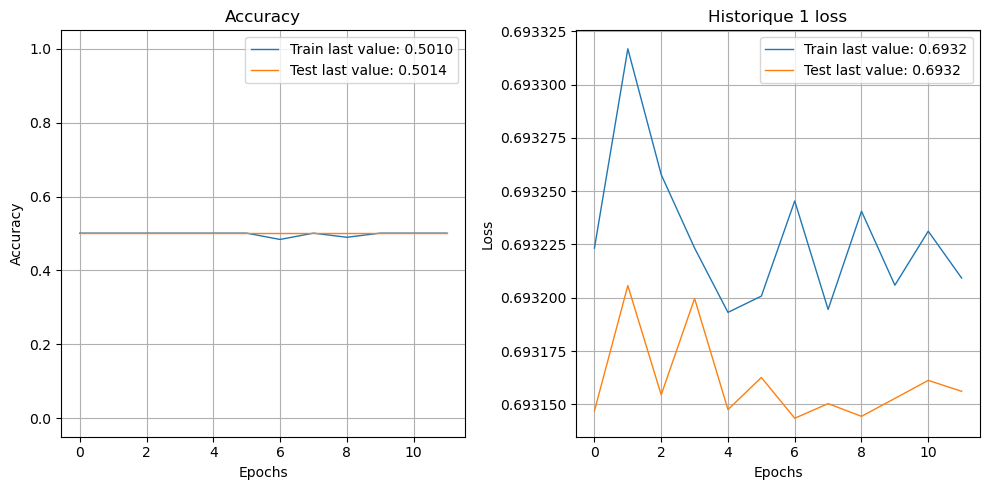

<Figure size 1000x500 with 0 Axes>

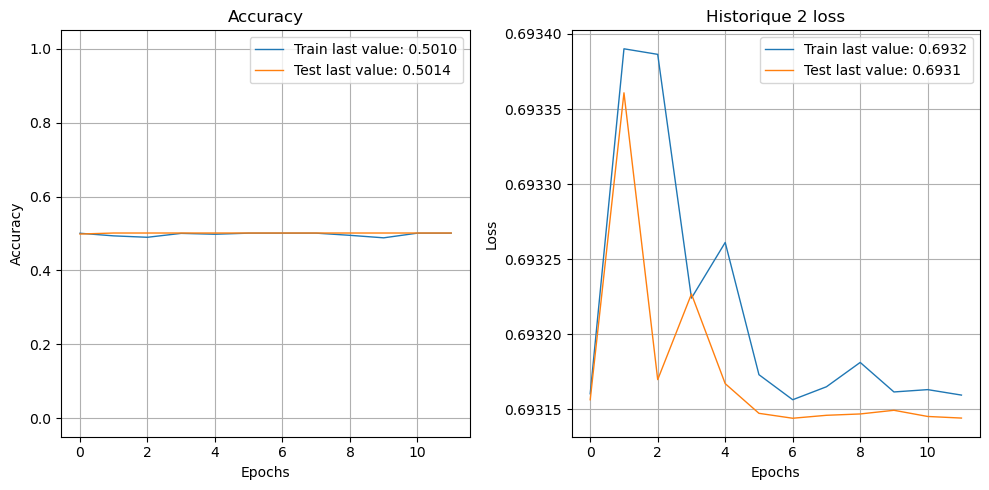

<Figure size 1000x500 with 0 Axes>

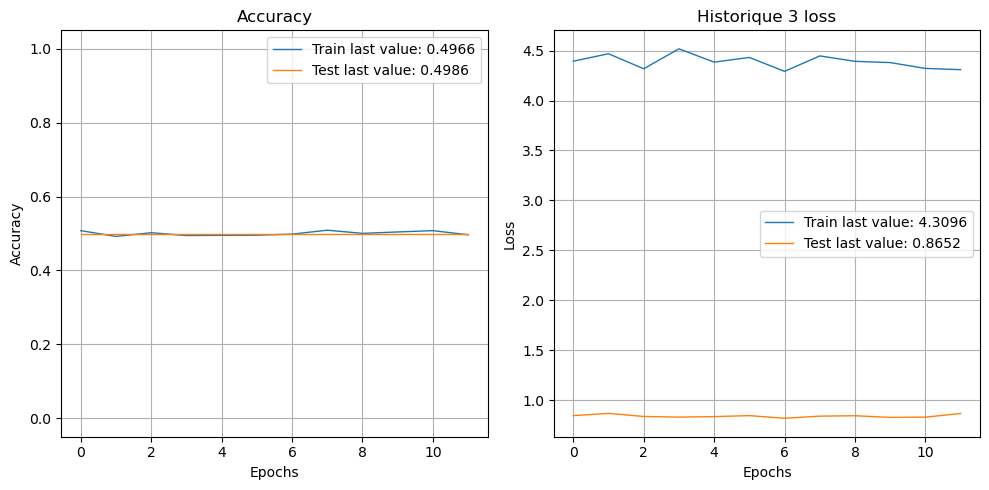

<Figure size 1000x500 with 0 Axes>

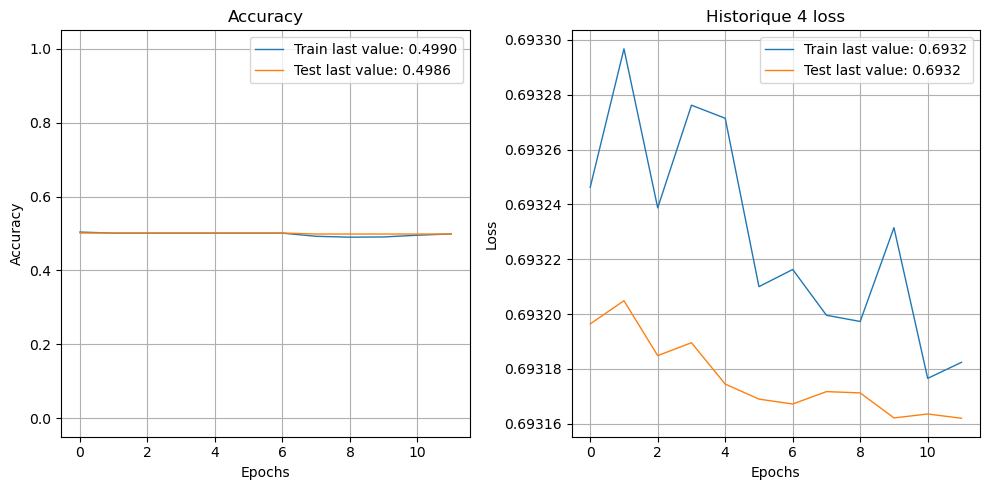

<Figure size 1000x500 with 0 Axes>

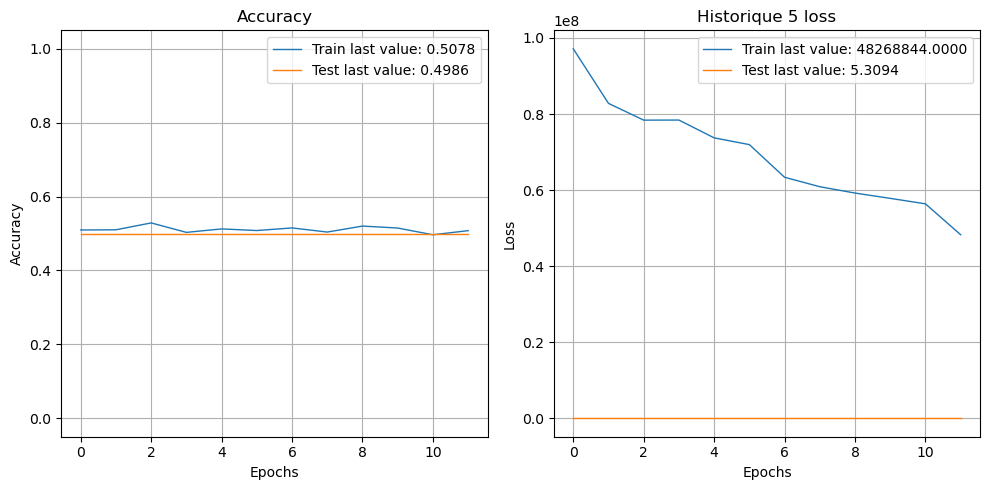

In [37]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# Supposons que tu as plusieurs historiques
histories = [history_w2v_1, history_w2v_2, history_w2v_3, history_w2v_4, history_w2v_5]  

# Afficher chaque historique dans un nouveau graphe
for i, history in enumerate(histories):
    plt.figure(figsize=(10, 5))  # Cr√©er une nouvelle figure pour chaque historique
    plot_history(history.history)  # Afficher l'historique
    plt.title(f'Historique {i+1} loss')  # Ajouter un titre sp√©cifique
    plt.tight_layout()  # Ajuster les espacements
    plt.show()

### Enregistrement des essais

In [38]:
# Fonction pour logger un historique d'entra√Ænement
def log_history(history, history_index):
    for key in history.history.keys():
        for epoch, value in enumerate(history.history[key]):
            mlflow.log_metric(f"{key}_history_{history_index}", value, step=epoch)

In [40]:
# Fonction pour logger un graphe de l'historique
def log_history_plot(history, history_index):
    plt.figure(figsize=(10, 5))
    plot_history(history.history)
    plt.title(f'Historique {history_index}')
    
    # Sauvegarder l'image du graphe localement
    plot_path = f"history_plot_{history_index}.png"
    plt.savefig(plot_path)
    plt.close()  # Fermer le graphe pour ne pas l'afficher
    
    # Logger le graphe comme artefact dans MLflow
    mlflow.log_artifact(plot_path)

In [41]:
# D√©marrer une nouvelle session MLflow
mlflow.start_run(run_name="Entra√Ænement de mod√®les tests avec Word2Vec")

<ActiveRun: >

In [42]:
# La liste d'histories est d√©j√† d√©finie
models = [model_W2v_1, model_W2v_2, model_W2v_3, model_W2v_4, model_W2v_5]  # Remplace par tes mod√®les

In [43]:
# Boucle sur les mod√®les et historiques pour les logger dans MLflow
for i, (model, history) in enumerate(zip(models, histories)):
    # Logger le mod√®le
    mlflow.keras.log_model(model, f"model_{i+1}")

    # Logger les m√©triques de l'historique
    log_history(history, i+1)

    # Logger les graphes d'historique
    log_history_plot(history, i+1)

2024/10/17 11:27:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/17 11:27:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 11:27:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/17 11:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 11:27:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/17 11:28:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/17 11:28:02 WARNING mlflow.keras.save: You are saving a Keras model 

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [44]:
# Terminer la session MLflow
mlflow.end_run()

2024/10/17 11:28:13 INFO mlflow.tracking._tracking_service.client: üèÉ View run Entra√Ænement de mod√®les tests avec Word2Vec at: http://localhost:5000/#/experiments/566106427225564143/runs/8be0140f82444cc1aaa809f4695eae08.
2024/10/17 11:28:13 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Optimisation automatique du mod√®le d'embedding

Utilisation de <u><b>Keras tuner</b></u> pour optimiser le mod√®le en faisant varier:<br>
- le nombre d'unit√©s GRU
- le taux de dropout
- la r√©gularisation L2
- le taux d'apprentissage

In [ ]:
# pip install keras-tuner --upgrade

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Fonction de cr√©ation du mod√®le pour Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Word2Vec pr√©-entra√Æn√©e
    model.add(Embedding(
        input_dim=vocab_size,        
        output_dim=w2v_size,         
        weights=[embedding_matrix],  
        # input_length=maxlen,         
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparam√®tres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),  # Intervalle √©largi
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),  # Dropout plus √©lev√©
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec r√©gularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))

    # Compilation du mod√®le
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instanciation du tuner pour rechercher les hyperparam√®tres
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_bidirectional_tuning'
)

# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparam√®tres
tuner.search(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

# R√©cup√©ration des meilleurs hyperparam√®tres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Entra√Æner le meilleur mod√®le avec ces hyperparam√®tres
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])


In [ ]:
# Plot de l'historique de l'entra√Ænement
plot_history(history.history)

In [ ]:
# Affichage des meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres trouv√©s :")
print(f" - Units dans LSTM : {best_hps.get('units')}")
print(f" - Lambda de r√©gularisation L2 : {best_hps.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps.get('dropout_rate')}")
print(f" - Learning rate : {best_hps.get('learning_rate')}")

# Construire le meilleur mod√®le avec les meilleurs hyperparam√®tres
# Sp√©cifier l'input_shape correspondant √† tes donn√©es (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le mod√®le explicitement avec la taille d'entr√©e
best_model.build(input_shape=(None, *input_shape))  # None correspond √† la taille du batch

# Affichage du r√©sum√© du mod√®le
best_model.summary()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des pr√©dictions sur le jeu de test
y_pred_probs = best_model.predict(test_padded)  # Pr√©dictions en probabilit√©s
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('V√©rit√©s terrain')
plt.show()

# 4. Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


# Glove

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Param√®tres
EMBEDDING_DIM = 200  # Dimension des embeddings Glove, ex: 50, 100, 200
MAX_NB_WORDS = 10000  # Limite de vocabulaire (nombre maximal de mots)
MAX_SEQUENCE_LENGTH = 40  # Longueur maximale des s√©quences de texte

# Charger les embeddings Glove
def load_glove_embedding(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'{len(embeddings_index)} mots vectoris√©s charg√©s depuis Glove.')
    return embeddings_index

# Chargement du fichier Glove twitter 27B (200)
glove_embeddings_index = load_glove_embedding('./Glove/glove.twitter.27B.200d.txt', EMBEDDING_DIM)

In [ ]:
# Tokenizer - cr√©er un index pour chaque mot dans les donn√©es
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df['preprocessed_text'].values)

# Convertir les textes en s√©quences
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'].values)

# Appliquer le padding aux s√©quences pour les rendre de longueur √©gale
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Cr√©er la matrice d'embeddings
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))  # Nombre total de mots dans le tokenizer

embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))  # Ajouter +1 pour l'index 0 (padding)

for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Si le mot est trouv√© dans Glove

print(f"Matrice d'embeddings cr√©√©e avec une dimension de {embedding_matrix.shape}")

# Vos labels
y_train = train_df['target'].values
y_test = test_df['target'].values

## Essai d'optimisation du mod√®le performant avec W2Vec

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.regularizers import l2
from keras.optimizers import Adam

# Fonction de cr√©ation du mod√®le pour Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec avec une embedding_matrix pr√©-entra√Æn√©e
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],  # Nombre total de mots dans la matrice d'embedding
        output_dim=embedding_matrix.shape[1],  # Dimension des embeddings Glove (par exemple, 200)
        weights=[embedding_matrix],              # Matrice d'embedding pr√©-entra√Æn√©e
        trainable=False                          # Ne pas entra√Æner la matrice d'embedding
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparam√®tres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec r√©gularisation L2
    model.add(Dense(
        units=1,                               # Pour une classification binaire
        activation='sigmoid',                  # Activation sigmo√Øde pour la sortie binaire
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))

    # Compilation du mod√®le
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',            # Fonction de perte pour la classification binaire
        metrics=['accuracy']                    # Mesure de performance
    )

    return model


In [ ]:
# Instanciation du tuner pour rechercher les hyperparam√®tres
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='lstm_bidirectional_tuning'
)

# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparam√®tres
tuner.search(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

# R√©cup√©ration des meilleurs hyperparam√®tres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Entra√Æner le meilleur mod√®le avec ces hyperparam√®tres
best_model_glove = tuner.hypermodel.build(best_hps)
history = best_model_glove.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

In [ ]:
# Plot de l'historique de l'entra√Ænement
plot_history(history.history)

In [ ]:
# Affichage des meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres trouv√©s :")
print(f" - Units dans LSTM : {best_hps.get('units')}")
print(f" - Lambda de r√©gularisation L2 : {best_hps.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps.get('dropout_rate')}")
print(f" - Learning rate : {best_hps.get('learning_rate')}")

# Construire le meilleur mod√®le avec les meilleurs hyperparam√®tres
# Sp√©cifier l'input_shape correspondant √† tes donn√©es (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le mod√®le explicitement avec la taille d'entr√©e
best_model.build(input_shape=(None, *input_shape))  # None correspond √† la taille du batch

# Affichage du r√©sum√© du mod√®le
best_model.summary()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des pr√©dictions sur le jeu de test
y_pred_probs = best_model.predict(test_padded)  # Pr√©dictions en probabilit√©s
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('V√©rit√©s terrain')
plt.show()

# 4. Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


# Mod√®le bas√© sur Bert (pr√©-entrain√©)

In [ ]:
# pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to preprocess the text and make predictions
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted sentiment label
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map the prediction to the sentiment
    sentiment_labels = ['negative', 'neutral', 'positive']
    return sentiment_labels[predicted_class]

# Example usage
text = "I love using the new RoBERTa model for sentiment analysis!"
sentiment = predict_sentiment(text)
print(f"Sentiment: {sentiment}")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment
def predict_sentiment_roberta(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)

    return predicted_classes

# Mapping the RoBERTa outputs to your target classes (0 = positive, 1 = negative)
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa has 3 classes: [negative, neutral, positive]
    # We'll map neutral and negative to 'negative' (1), positive to 'positive' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Process the DataFrame and predict sentiments for train/test data
def process_and_predict(df):
    predicted_labels = []

    for text in df['text']:
        # Predict sentiment for each tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()

        # Map RoBERTa sentiment to custom labels
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)

    return predicted_labels

# Predict on training set
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

# Predict on test set
test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# Evaluate the results
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Classification report for further insights
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


# Test Roberta tweets sentiment analysis avec fine-tuning

In [ ]:
import torch
print("CUDA disponible:", torch.cuda.is_available())  # Devrait retourner True
print("Nom du GPU:", torch.cuda.get_device_name(0))   # Affiche le nom du GPU
print("Version de PyTorch:", torch.__version__)       # Devrait afficher 2.4.1


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]

        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# # Sous-√©chantillonage de train_df
# from sklearn.model_selection import train_test_split

# # Taille de l'√©chantillon (20% du total)
# sample_size = 0.2

# # Cr√©ation du sous-√©chantillon avec stratification sur la colonne 'target'
# train_sample, _ = train_test_split(train_df,
#                                    test_size=1 - sample_size,
#                                    stratify=train_df['target'],
#                                    random_state=42)

# # Affichage de la r√©partition des classes dans le sous-√©chantillon
# print(train_sample['target'].value_counts(normalize=True))

In [ ]:
# Recap mod√®le et assignation de device pour le calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from tweet_dataset import TweetDataset  # Importer la classe depuis le module s√©par√©

# Function to create the DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4  # Adjust according to your machine
    )

In [ ]:
# Main execution block
if __name__ == "__main__":
    maxlen = 40  # Max tokens
    batch_size = 16  # Increase to lower calculation time

    # Prepare the data
    train_dataloader = create_data_loader(train_df, tokenizer, maxlen, batch_size)
    test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)
    # Example usage of DataLoader (test de l'utilisation de la classe tweet_dataset
    # for batch in train_dataloader:
    #     print(batch)
    #     break  # Remove this line to process the full dataset

In [ ]:
from torch.optim import AdamW
# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [ ]:
epochs = 20  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import recall_score
# import matplotlib.pyplot as plt

# # Function to calculate recall (as a callback metric)
# def calculate_recall(y_true, y_pred):
#     y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
#     y_true = y_true.cpu().numpy()
#     return recall_score(y_true, y_pred, average='macro')

In [ ]:
# # Train and evaluation function
# def train_epoch(model, dataloader, optimizer, device):
#     model.train()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in dataloader:
#         optimizer.zero_grad()
#         inputs = batch['input_ids'].to(device)
#         masks = batch['attention_mask'].to(device)
#         targets = batch['targets'].to(device)

#         outputs = model(input_ids=inputs, attention_mask=masks).logits
#         loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == targets)
#         total_predictions += targets.size(0)

#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses)

# def eval_model(model, dataloader, device):
#     model.eval()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0
#     recalls = []

#     with torch.no_grad():
#         for batch in dataloader:
#             inputs = batch['input_ids'].to(device)
#             masks = batch['attention_mask'].to(device)
#             targets = batch['targets'].to(device)

#             outputs = model(input_ids=inputs, attention_mask=masks).logits
#             loss = torch.nn.CrossEntropyLoss()(outputs, targets)

#             _, preds = torch.max(outputs, dim=1)
#             correct_predictions += torch.sum(preds == targets)
#             total_predictions += targets.size(0)
            
#             # Recall calculation
#             recalls.append(calculate_recall(targets, outputs))

#             losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses), np.mean(recalls)

In [ ]:
# # Training loop with callbacks, early stopping and history tracking
# def train_model(model, train_dataloader, test_dataloader, optimizer, epochs, device, patience=3):
#     history = {
#         'train_loss': [],
#         'test_loss': [],
#         'train_recall': [],
#         'test_recall': []
#     }

#     best_recall = 0
#     early_stopping_counter = 0

#     for epoch in range(epochs):
#         # Training
#         train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
#         # Evaluation
#         test_acc, test_loss, test_recall = eval_model(model, test_dataloader, device)
        
#         # Save metrics to history
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_recall'].append(train_acc)
#         history['test_recall'].append(test_recall)

#         # Print progress
#         print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Recall: {test_recall:.4f}')

#         # Early stopping based on loss improvement
#         if test_recall > best_recall:
#             best_recall = test_recall
#             early_stopping_counter = 0
#             # Optionally save the best model here
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             early_stopping_counter += 1

#         if early_stopping_counter >= patience:
#             print(f"Early stopping after {epoch + 1} epochs")
#             break

#     # Save history to a file
#     with open('history.npy', 'wb') as f:
#         np.save(f, history)

#     # Plot loss and recall
#     plot_history(history)

In [ ]:
# def plot_history(history):
#     epochs = len(history['train_loss'])
#     plt.figure(figsize=(14, 5))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(range(epochs), history['train_loss'], label='Train Loss')
#     plt.plot(range(epochs), history['test_loss'], label='Test Loss')
#     plt.legend()
#     plt.title('Loss Evolution')
    
#     # Plot recall
#     plt.subplot(1, 2, 2)
#     plt.plot(range(epochs), history['train_recall'], label='Train Recall')
#     plt.plot(range(epochs), history['test_recall'], label='Test Recall')
#     plt.legend()
#     plt.title('Recall Evolution')

#     plt.show()

In [ ]:
# train_model(model, train_dataloader, test_dataloader, optimizer, epochs=5, device=device)

In [ ]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

# Save the model
model_save_path = f'./models/roberta_fine_tuned_{dt_string}'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")